上篇文章通过研究订单到达间隔，展示了为什么要动态调整对参数以及如何评价估计的好坏。本篇文章将聚焦深度数据，研究中间价mid-price(或者叫fair-price,micro-price等等）。

### 深度数据

币安提供了最优报价的历史数据下载，包含best_bid_price:最优买价，即最大的买价，best_bid_qty：最优买价的数量，best_ask_price：最优卖价，best_ask_qty：最优卖价的数量，transaction_time：时间戳。这个数据不包含第二档以及更深的挂单。这里分析的行情时8月7号的YGG，这一天行情波动十分剧烈，数据量也达到了900多万条。

首先看下当天的行情，大起大落，另外当天的盘口挂单量也随着行情的波动而发生了较大变化，特别是spread（卖一价与买一价的差）非常显著的表明了行情的波动情况。对YGG当天行情的统计中，有20%的时间spread大于1个tick，在这个各种机器人在盘口竞争的时代，这种情况已经很少见了。

In [1]:
from datetime import date,datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
books = pd.read_csv('YGGUSDT-bookTicker-2023-08-07.csv')

In [3]:
tick_size = 0.0001

In [4]:
books['date'] = pd.to_datetime(books['transaction_time'], unit='ms')
books.index = books['date']

In [5]:
books['spread'] = round(books['best_ask_price'] - books['best_bid_price'],4)

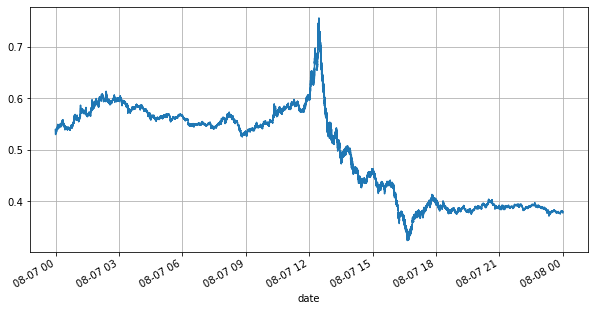

In [6]:
books['best_bid_price'][::10].plot(figsize=(10,5),grid=True);

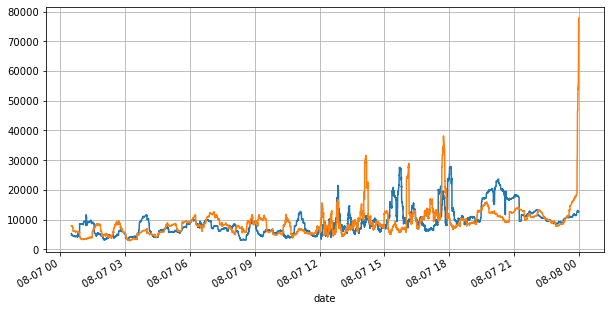

In [7]:
books['best_bid_qty'][::10].rolling(10000).mean().plot(figsize=(10,5),grid=True);
books['best_ask_qty'][::10].rolling(10000).mean().plot(figsize=(10,5),grid=True);

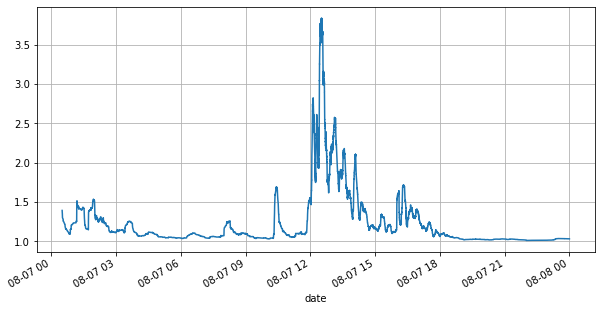

In [8]:
(books['spread'][::10]/tick_size).rolling(10000).mean().plot(figsize=(10,5),grid=True);

In [9]:
books['spread'].value_counts()[books['spread'].value_counts()>500]/books['spread'].value_counts().sum()

0.0001    0.799169
0.0002    0.102750
0.0003    0.042472
0.0004    0.022821
0.0005    0.012792
0.0006    0.007350
0.0007    0.004376
0.0008    0.002712
0.0009    0.001657
0.0010    0.001089
0.0011    0.000740
0.0012    0.000496
0.0013    0.000380
0.0014    0.000258
0.0015    0.000197
0.0016    0.000140
0.0017    0.000112
0.0018    0.000088
0.0019    0.000063
Name: spread, dtype: float64

### 不平衡报价

从上面可以看到买单和卖单挂单量大部分时间都相差很大，这个差别对市场短期行情有很强的预测作用。原因同前面文章提到到买单量小往往下跌的原因差不多。如果一侧挂单显著小于另一侧，假设接下来主动买卖订单的量接近，挂单小的一侧会有更大的可能性被吃掉，从而推动价格的变化。不平衡报价用I表示：
$$I=\frac{Q_b}{Q_b+Q_a}$$
其中Q_b代表买单挂单量（best_bid_qty），Q_a代表卖单挂单量（best_ask_qty）。

定义 mid-price: $$P_m=\frac{P_b+P_a}{2}$$

下图展示了mid-price接下来1个间隔的变化率和不平衡I的关系，和预期的一致，随着I的增大，价格越可能上涨，且越接近1，价格变化的幅度也在加快。高频交易中，引入中间价的目的是为了更好的预测未来价格的变化，也就是和未来的价格差异越小，中间价就定义的越好。显然挂单的不平衡为策略的预测提供了额外的信息，考虑到这一点，定义weighted mid-price:
$$P_{wm} =P_b (1-I) +P_a I$$

In [10]:
books['I'] = books['best_bid_qty'] / (books['best_bid_qty'] + books['best_ask_qty'])

In [11]:
books['mid_price'] = (books['best_ask_price'] + books['best_bid_price'])/2

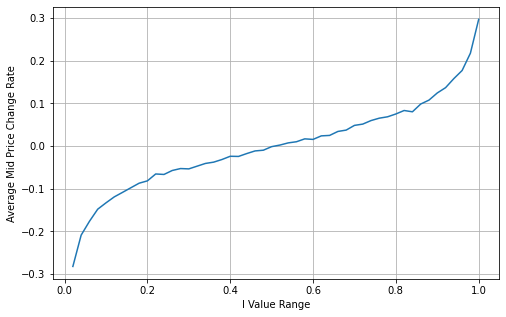

In [12]:
bins = np.linspace(0, 1, 51)
books['I_bins'] = pd.cut(books['I'], bins, labels=bins[1:])
books['price_change'] = (books['mid_price'].pct_change()/tick_size).shift(-1)
avg_change = books.groupby('I_bins')['price_change'].mean()
plt.figure(figsize=(8,5))
plt.plot(avg_change)
plt.xlabel('I Value Range')
plt.ylabel('Average Mid Price Change Rate');
plt.grid(True)

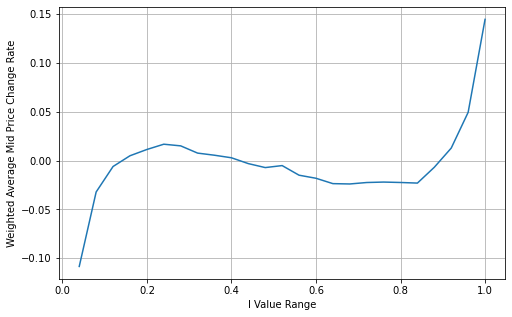

In [13]:
books['weighted_mid_price'] = books['mid_price'] + books['spread']*books['I']/2
bins = np.linspace(-1, 1, 51)
books['I_bins'] = pd.cut(books['I'], bins, labels=bins[1:])
books['weighted_price_change'] = (books['weighted_mid_price'].pct_change()/tick_size).shift(-1)
avg_change = books.groupby('I_bins')['weighted_price_change'].mean()
plt.figure(figsize=(8,5))
plt.plot(avg_change)
plt.xlabel('I Value Range')
plt.ylabel('Weighted Average Mid Price Change Rate');
plt.grid(True)

### 调整加权中间价

从图上来看weighted mid-price相对于不同I的变化小了很多，这说明加权中间价是个更好的拟合。但仍然有一些规律，如0.2和0.8附近，偏差较大。这说明I依然可以贡献额外的信息。因为weighted mid-price假设价格修正项与I是完全线性的，这显然不符合实际，从上图可以看出，当I接近0和1时，偏离的速度更快，不是线性关系。

为了更加直观，这里重新定义下I：$$I=\frac{Q_b-Q_a}{Q_b+Q_a}$$
此时：$$P_{wm} =P_m +(P_a-P_b)\frac{I}{2}$$

观察这种形式，可以发现加权中间价是对平均中间价的修正，修正项的系数是Spread，而修正项是关于I的函数，weighted mid-price简单假设这个关系是I/2 。这时候调整后的I的分布(-１,１)的好处体现了出来，I关于原点对称，这为我们找到函数的拟合关系提供了方便。观察图形，这种函数应该满足I的奇次幂的关系，这样符合两边增长的快，并且关于原点对称，另外还可以观察到，原点附近的值接近线性，再加上当I取0时，函数结果为0，当I为1时，函数结果为0.5。所以猜测这个函数形如：$$\frac{I(I^N+1)}{4}$$

这里的N为正偶数，经过实际的测试，N为8时比较好。至此本文提出了修正后的加权中间价：$$P_{awm} =P_m +(P_a-P_b)\frac{I(I^8+1)}{4}$$

此时预测中间价的变动和I基本没有关系了。这个结果虽然比简单的加权中间价好一些，但也不是实盘可以应用的，这里只是给出一个思路。S Stoikov一篇2017年的文章用马尔可夫链的方法介绍了[Micro-Price](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2970694)，并且给出了相关的代码，大家也可以研究下。


In [14]:
books['I'] = (books['best_bid_qty'] - books['best_ask_qty']) / (books['best_bid_qty'] + books['best_ask_qty'])

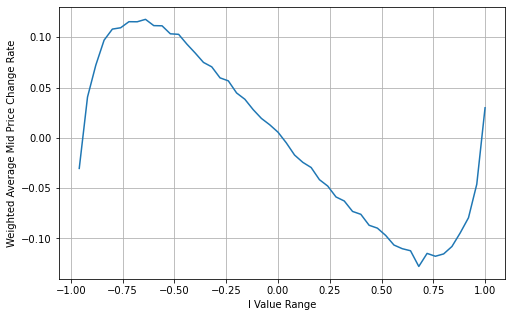

In [15]:
books['weighted_mid_price'] = books['mid_price'] + books['spread']*books['I']/2
bins = np.linspace(-1, 1, 51)
books['I_bins'] = pd.cut(books['I'], bins, labels=bins[1:])
books['weighted_price_change'] = (books['weighted_mid_price'].pct_change()/tick_size).shift(-1)
avg_change = books.groupby('I_bins')['weighted_price_change'].mean()
plt.figure(figsize=(8,5))
plt.plot(avg_change)
plt.xlabel('I Value Range')
plt.ylabel('Weighted Average Mid Price Change Rate');
plt.grid(True)

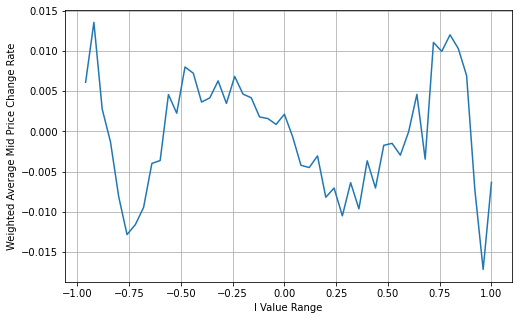

In [16]:
books['adjust_mid_price'] = books['mid_price'] + books['spread']*books['I']*(books['I']**8+1)/4
bins = np.linspace(-1, 1, 51)
books['I_bins'] = pd.cut(books['I'], bins, labels=bins[1:])
books['adjust_mid_price'] = (books['adjust_mid_price'].pct_change()/tick_size).shift(-1)
avg_change = books.groupby('I_bins')['adjust_mid_price'].mean()
plt.figure(figsize=(8,5))
plt.plot(avg_change)
plt.xlabel('I Value Range')
plt.ylabel('Weighted Average Mid Price Change Rate');
plt.grid(True)

### 总结

中间价对于高频策略非常重要，是对未来短期价格的预测，因此中间价要尽可能的精确。前面介绍的中间价都是基于盘口数据，这是因为分析的时候只用到了一档行情。实盘中，策略要尽可能用到所有的数据，特别是实盘中有trades成交流，对中间价的预测应该由实际成交价来检验。记得Stoikov好像发过一个推，说真实的中间价应该是买一卖一成交概率的加权平均，这个问题前面的文章刚好研究过。限于篇幅，下篇文章再详细展开这些问题。